# Kaggle Taxi Cab Analysis

## Loading Libraries and Datasets

Importing pandas, pytorch and numpy

In [1]:
import pandas as pd
import torch, numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 1.9.0+cu111


Read in the train.csv file into a pandas dataframe.

In [34]:
df_tr = pd.read_csv("train.csv")

In [39]:
print(df_tr.shape)
df_tr.head()

(1710660, 9)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


Removing the 10 trips with MISSING_DATA true meaning they have no POLYLINE and thus no travel time.

In [36]:
missingIndex = df[df["MISSING_DATA"]].index
df_tr.drop(missingIndex , inplace=True)

In [40]:
print(df_tr.shape)
df_tr.head()

(1710660, 9)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# Get Computed Travel Time

Add a "LEN" column to the dataframe with a trip's travel time calculated by getting the number of elements in the POLYLINE and multiplying by 15 seconds. A single element in the POLYLINE represents a start longtitude/latitude and an end longtitude/latitude and represents 15 seconds of travel.

In [41]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

Translates the TIMESTAMP which is in epoch time into YR, MON, DAY, HR, WK columns.

In [137]:
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")


In [138]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,HR,YR,MON,DAY,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,0,2013,7,1,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,0,2013,7,1,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,0,2013,7,1,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,0,2013,7,1,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,0,2013,7,1,0


# Feature Engineering

For this, the chosen features are the hours, month and day that the trip occured on. Instead of the categorical representation, their one hot representations will be used. These will be combined into a tensor with the shape [1710660, 69] or in otherwords we have 1710660 feature vectors each of length 69. The length of the trips will be turned into a tensor as well and we want its shape to be [1710660, 1] so we might need to reshape it.

In [144]:
def transform(data, num_category):
    one_hot = np.zeros(num_category)
    one_hot[data] = 1
    return one_hot

def transform24(data):
    return transform(data, 24)

def transform12(data):
    return transform(data, 13)

def transform32(data):
    return transform(data, 32)
one_hot_hours = df_tr["HR"].apply(transform24)
one_hot_month = df_tr["MON"].apply(transform12)
one_hot_days = df_tr["DAY"].apply(transform32)

In [145]:
#turn the three series into tensors and concat them horizontally
hours = torch.tensor(one_hot_hours, dtype=torch.float32)
month = torch.tensor(one_hot_month, dtype=torch.float32)
days = torch.tensor(one_hot_days, dtype=torch.float32)
raw_X = torch.cat((hours, month), dim=1)
raw_X = torch.cat((raw_X, days), dim=1)

In [146]:
#the y values will be the actual trip times
raw_y = torch.tensor(df_tr["LEN"], dtype=torch.float32)

In [147]:
print(raw_X)
print(raw_y)
print(f"{raw_X.shape=} {raw_X.size()=}") 
print(f"{raw_y.shape=} {raw_y.size()=}") 

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
tensor([330., 270., 960.,  ...,   0., 915., 390.])
raw_X.shape=torch.Size([1710660, 69]) raw_X.size()=torch.Size([1710660, 69])
raw_y.shape=torch.Size([1710660]) raw_y.size()=torch.Size([1710660])


In [148]:
#randomly populate the training and testing set with 1.5 million in the training and the rest in the testing
perm = torch.randperm(df_tr["LEN"].size)
train_idx, test_idx = perm[:1500000], perm[1500000:]
X_tr, y_tr = raw_X[train_idx], raw_y[train_idx]
X_te, y_te = raw_X[test_idx], raw_y[test_idx]
print(X_tr.shape, X_te.shape)
print(y_tr.shape, y_te.shape)

torch.Size([1500000, 69]) torch.Size([210660, 69])
torch.Size([1500000]) torch.Size([210660])


In [149]:
#do any reshapings that has to be done
X_train, X_test = X_tr.reshape((-1, 69)), X_te.reshape((-1, 69))
y_train, y_test = y_tr.reshape((-1, 1)), y_te.reshape((-1, 1))
print(X_train)
print(y_train)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 540.],
        [ 840.],
        [ 420.],
        ...,
        [ 750.],
        [1350.],
        [ 225.]])
torch.Size([1500000, 69]) torch.Size([210660, 69])
torch.Size([1500000, 1]) torch.Size([210660, 1])


# Creating Model

This follows the Discussion 2 regression.ipynb code where it creates a Linear model, chooses the Mean Square Error Loss Function, and chooses SGD as the optimizer. Discussion 3 has another way of doing this where a new Model class is defined instead as well as classes are defined for DataLoading and more. 

In [153]:
# Define Model

model = torch.nn.Sequential(
  torch.nn.Linear(69, 1),
    #we can stack this if we want more layers
    #eg. torch.nn.Linear(1, 1),
    #   torch.nn.Linear(1, 1),
)

# Define Loss Function / Objective Function
loss_fn = torch.nn.MSELoss()
#pytorch has default loss functions but you can pass in in your own loss function

# Define optimizer (this will perform your parameter updates use)
lr = 5e-3
opt = torch.optim.SGD(model.parameters(), lr=lr)
#we have to choose an optimizer, how params are updated, in this case we use SGD - standard gradient ascent and we pass in
#the parameter's model, lr is the step rate, smaller = slower and precise, large = faster but can be unstable / overshoot

In [155]:
train_err = []
test_err = []
parameters = []
for i in range(10000):
  # have to call this when we want to start training
  model.train()
  
  # will predict the values of y for the dataset consisting of x coordinates
  y_pred = model(X_train) # Compute model outputs
  
  #calculates the loss between the prediction and the training data, should always be some loss    
  loss = loss_fn(y_pred, y_train) # Compute MSE
  

  #clears optimizer / gradient through each iteration
  opt.zero_grad() # Must reset the gradients every step. Otherwise, gradients from previous iterations would cause interference!!!
  
  loss.backward() # Compute gradients of all parameters (our model) with respect to our computed loss value (a singular value)
  
  opt.step() # One gradient step
  
#   print(loss, end="")
  #save loss rate to see how well our model is doing every step in regards to training data
  train_err.append(loss.item())
  
  # model.eval() enters evaluating mode to test with "unseen data"
  model.eval()
  #torch.no_grad will stop from caculating gradient, we dont want to perform gradient descent so performance 
  with torch.no_grad():
    #model predicts test data and we caclulate the loss to the actual test data
    test_err.append(loss_fn(model(X_test), y_test).item())

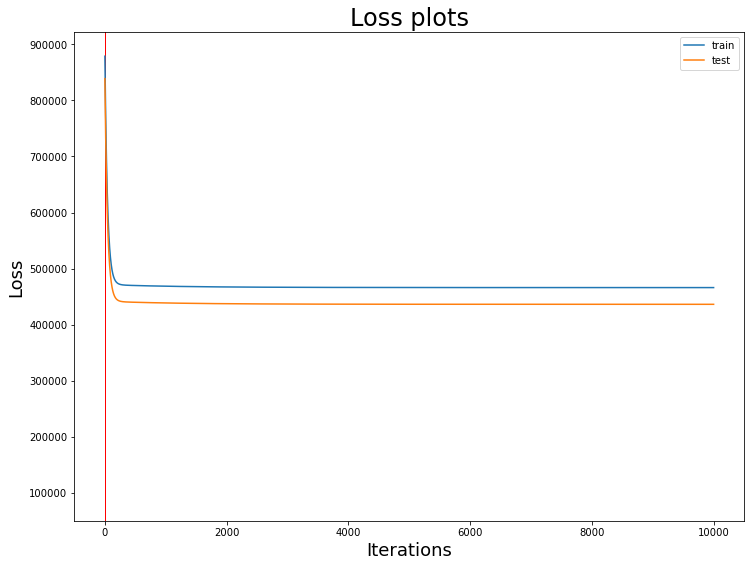

In [158]:
def visualize_graphs(train_err, test_err, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red", lw=1)
  plt.axvline(color="red", lw=1)
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  
  plt.plot(train_err, label="train")
  plt.plot(test_err, label="test")
  
  plt.ylim(50000)
  
  plt.legend(loc="upper right")
  
  
visualize_graphs(train_err, test_err, "Loss plots")

# Create Prediction File

After the model has been trained, we can then run it on the public test cases. The public test cases are given in the test_public.csv file. The same transformation we applied to the training dataset has to be done to the test_public.csv file in order to run the model on it.

In [159]:
predict = pd.read_csv("test_public.csv")

In [160]:
predict[["YR", "MON", "DAY", "HR", "WK"]] = predict[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [164]:
predict_one_hot_h = predict["HR"].apply(transform24)
predict_one_hot_m = predict["MON"].apply(transform12)
predict_one_hot_d = predict["DAY"].apply(transform32)

hoursP = torch.tensor(predict_one_hot_h, dtype=torch.float32)
monthP = torch.tensor(predict_one_hot_m, dtype=torch.float32)
daysP = torch.tensor(predict_one_hot_d, dtype=torch.float32)
predict_hour = torch.cat((hoursP, monthP), dim=1)
predict_hour = torch.cat((predict_hour, daysP), dim=1)

model.eval()
with torch.no_grad():
    o = model(predict_hour)

After getting the output from the model, there should be 320 datapoints. We can open the sampleSubmission.csv and then add a new column for the TRAVEL_TIME and put in our predicted travel time. The csv then can be saved.

In [165]:
df_sample = pd.read_csv("sampleSubmission.csv")

o = o.reshape(-1)
out = o.numpy()
for i in range(320):
    df_sample.at[i, "TRAVEL_TIME"] = out[i]

df_sample.to_csv("my_pred.csv", index=None)

# Saving Models

In [166]:
import os 
os.makedirs('./saves/', exist_ok=True)
torch.save(model.state_dict(), './saves/model_weights.pth')

After saving a model, you can load it back again like this. 

In [167]:
new_model = torch.nn.Sequential(
  torch.nn.Linear(69, 1),
    #we can stack this if we want more layers
    #eg. torch.nn.Linear(1, 1),
    #   torch.nn.Linear(1, 1),
)

In [168]:
# make sure the model is has the same "structure" so that the "weights" can be filled in.
new_model.load_state_dict(torch.load('./saves/model_weights.pth'))

<All keys matched successfully>